# Lab 3: Gaussian process regression

### Machine Learning 1, September 2016

* The lab exercises should be made in groups of two people.
* The deadline is October 30th (Sunday) 23:59 after the final exam.
* Assignment should be sent to your teaching assistant. The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: Make sure we can run your notebook / scripts!
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bxp}{\mathbf{x}^{'}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$
$\newcommand{\xm}{\mathbf{x}_m}$
$\newcommand{\xn}{\mathbf{x}_n}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\zero}{\mathbf{0}}$
$\newcommand{\yi}{\y_i}$
$\newcommand{\thetav}{\mathbf{\theta}}$
$\newcommand{\t}{\mathbf{t}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\tN}{\mathbf{t}_N}$
$\newcommand{\xN}{\mathbf{x}_N}$
$\newcommand{\k}{\mathbf{k}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\CN}{\mathbf{C}_N}$
$\newcommand{\KN}{\mathbf{K}_N}$
$\newcommand{\eyeN}{\mathbf{I}_N}$

# Gaussian process regression

For this Lab we will be refer to Bishop sections 6.4.2 and 6.4.3. You may also want to refer to Rasmussen's Gaussian Process text which is available online at http://www.gaussianprocess.org/gpml/chapters/ and especially to the project found at http://www.automaticstatistician.com/index.php by Ghahramani for some intuition in GP.  To understand Gaussian processes, it is highly recommended understand how marginal, partitioned Gaussian distributions can be converted into conditional Gaussian distributions.  This is covered in Bishop 2.3 and summarized in Eqns 2.94-2.98.




### Sinusoidal Data

We will use the same data generating function that we used previously for regression.  You can change sigma/beta, but keep it reasonable.  Definitely play around once you have things working.  Make use of these functions as you wish.

In [1]:
%pylab inline
import pylab as pp

Populating the interactive namespace from numpy and matplotlib


In [2]:
sigma = 0.5
beta  = 1.0 / pow(sigma,2) # this is the beta used in Bishop Eqn. 6.59
N_test = 100
x_test = np.linspace(-1,1,N_test); 
mu_test = np.zeros( N_test )

In [3]:
def true_mean_function( x ):
    return np.sin( 2*pi*(x+1) )

def add_noise( y, sigma ):
    return y + sigma*np.random.randn(len(y))

def generate_t( x, sigma ):
    return add_noise( true_mean_function( x), sigma )

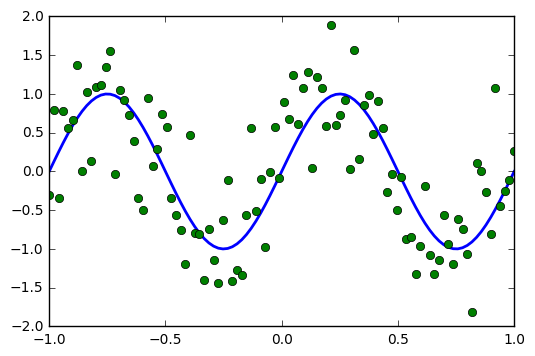

In [4]:
y_test = true_mean_function( x_test )
t_test = add_noise( y_test, sigma )
pp.plot( x_test, y_test, 'b-', lw=2)
pp.plot( x_test, t_test, 'go')

### 1. Sampling from the Gaussian process prior (30 points)

We will implement Gaussian process regression using the kernel function in Bishop Eqn. 6.63.  

#### 1.1 k_n_m( xn, xm, thetas ) (10 points)
To start, implement function "k_n_m( xn, xm, thetas )" that takes scalars $\xn$ and $\xm$, and a vector of $4$ thetas, and computes the kernel function Bishop Eqn. 6.63 (10 points). 

In [6]:
def k_n_m(xn, xm, thetas):
    # Bishop 6.63
    # Unravel thetas
    theta_0, theta_1, theta_2, theta_3 = thetas
    
    # Compute invdividual sum elements
    exponential = theta_0 * np.exp(-0.5 * theta_1 * (xn - xm)**2)
    constant = theta_2
    linear = theta_3 * np.dot(xn, xm)
    
    return exponential + constant + linear

#### 1.2 computeK( X1, X2, thetas ) (5 points)
Eqn 6.60 is the marginal distribution of mean ouput of $N$ data vectors: $p(\y) = \mathcal{N}(\zero, \K)$.  Notice that the expected mean function is $0$ at all locations, and that the covariance is a $N$ by $N$ kernel matrix $\K$.  Write a function "computeK( X1, X2, thetas )" that computes the kernel matrix. Hint: use k_n_m as part of an innner loop (of course, there are more efficient ways of computing the kernel function making better use of vectorization, but that is not necessary) (5 points).  

In [7]:
def computeK(X1, X2, thetas):
    # Compute covariance matrix using Bishop kernel 6.63 equation.
    return np.reshape([k_n_m(x1,x2,thetas) for x1 in X1 for x2 in X2], (len(X1), len(X2)))

#### 1.3 Plot function samples (15 points)
Now sample mean functions at the x_test locations for the theta values in Bishop Figure 6.5, make a figure with a 2 by 3 subplot and make sure the title reflects the theta values (make sure everything is legible).  In other words, sample $\yi \sim \mathcal{N}(\zero, \K_{\thetav})$.  Make use of numpy.random.multivariate_normal().  On your plots include the expected value of $\y$ with a dashed line and fill_between 2 standard deviations of the uncertainty due to $\K$ (the diagonal of $\K$ is the variance of the model uncertainty) (15 points).

/home/dana/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: covariance is not positive-semidefinite.


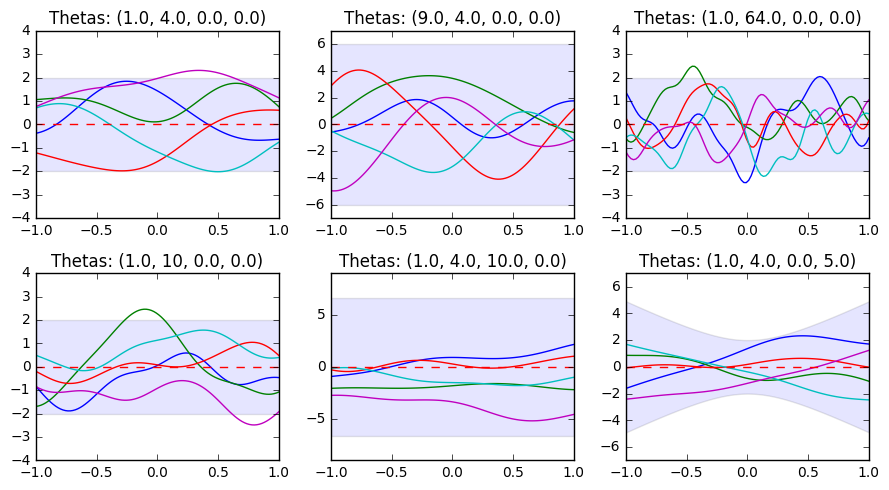

In [8]:

def Y(covariance, mean=None, samples=5):
    mu = mean if mean else np.zeros(covariance.shape[0])
    return np.random.multivariate_normal(mu, covariance, samples)

# Bishop's thetas 
thetas = [(1.0, 4.0, 0.0, 0.0), 
          (9.0, 4.0, 0.0, 0.0), 
          (1.0, 64.0, 0.0, 0.0), 
         (1.0, 10, 0.0, 0.0),
         (1.0, 4.0, 10.0, 0.0),
         (1.0, 4.0, 0.0, 5.0)]

# Compute covariance matrixes with kernel function
# defined for each theta parameter.
covs = [computeK(x_test, x_test, theta) for theta in thetas]

# Create plot
fig = plt.figure(figsize=(9,5))
for i in range(len(thetas)):
    # 5 samples for this specific kernel
    samples = Y(covs[i])
    
    # Create subplot
    subpl = fig.add_subplot(230 + (i+1))
    
    # Set subplot details
    subpl.set_title('Thetas: {0}'.format(str(thetas[i])))
    
    # Plot samples
    for j in range(len(samples)):
        subpl.plot(x_test, samples[j], '-')
        
    # Plot expected value
    subpl.plot(x_test, mu_test, 'r--')
    
    # Standard deviation
    std = np.sqrt(covs[i].diagonal())
    
    # Plot between standard deviations
    subpl.fill_between(x_test, mu_test + 2*std, mu_test - 2*std, alpha=0.1)
    
    # Layout constraints
    subpl.set_ylim(subpl.get_ylim()[0] - 1, subpl.get_ylim()[1] + 1) 
    
# Adjust plot spacing
plt.tight_layout()

### 2. Predictive distribution (35 points)

So far we have sampled mean functions from the prior.  We can draw actual data $\t$ two ways.  The first way is generatively, by first sampling $\y | \K$, then sampling $\t | \y, \beta$ (Eqns 6.60 followed by 6.59).  The second way is to integrate over $\y$ (the mean draw) and directly sample $\t | \K, \beta$ using Eqn 6.61.    This is the generative process for $\t$.  Note that we have not specified a distribution over inputs $\x$;  this is because Gaussian processes are conditional models.  Because of this we are free to generate locations $\x$ when playing around with the GP; obviously a dataset will give us input-output pairs.

Once we have data, we are interested in the predictive distribution (note: the prior is the predictive distribution when there is no data).  Consider the joint distribution for $N+1$ targets, given by Eqn 6.64.  Its covariance matrix is composed of block components $\CN$, $\k$, and $c$.  The covariance matrix $\CN$ for $\tN$ is $\CN = \KN + \eyeN / \beta$.  We have just made explicit the size $N$ of the matrix; $N$ is the number of training points.  The kernel vector $\k$ is a $N$ by $1$ vector of kernel function evaluations between the training input data and the test input vector.  The scalar $c$ is a kernel evaluation at the test input.

#### 2.1 gp_predictive_distribution(...) (10 points)
Write a function "gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C = None)" that computes  Eqns 6.66 and 6.67, except allow for an arbitrary number of test points (not just one) and now the kernel matrix is for training data.  By having C as an optional parameter, we can avoid computing it more than once (for this problem it is unimportant, but for real problems this is an issue).  The function should compute $\C$, $\k$ and $c$, and return the mean and noise functions.  Do not forget: the computeK function computes $\K$, not $\C$! (10 points)

In [11]:
def noisy_covariance(x, theta, beta):
    K = computeK(x, x, theta)
    C = K + np.identity(x.shape[0])*(1/beta)
    return C

def gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None, invC=None):
    if C is None:
        C = noisy_covariance(x_train, theta, beta)
    
    if invC is None:
        invC = np.linalg.inv(C)
    
    # initialize
    mean = np.zeros(len(x_test))
    var = np.zeros(mean.shape)
    
    k_conditional = computeK(x_train, x_test, theta)
    
    # For each testing point
    for i in range(x_test.shape[0]):
        x = x_test[i]
        c = k_n_m(x, x, theta) + (1 / beta)
        k = k_conditional[:,i]
        mean[i] = dot(k.T, dot(invC, t_train.reshape(t_train.shape[0],-1)))
        var[i] = c - k.T.dot(invC.dot(k))
    
    return mean, var

mean_pred, var_pred  = gp_predictive_distribution(x_test, t_test, np.asarray([1]), thetas[0], beta)

# Should be close to 1
print mean_pred, var_pred

[-0.15573063] [ 0.28773758]


#### 2.2 gp_log_likelihood(...) (10 points)
Later, to learn the hyperparameters, we will need to compute the log-likelihood of the of the training data.  Implicitly, this is conditioned on the value setting for $\thetav$.  Write a function "gp_log_likelihood( x_train, t_train, theta, C = None, invC = None, beta = None)", where C and invC can be stored and reused.  (10 points) Note: you need to add beta if you want to calculate C.

In [12]:
def gb_log_likelihood(x_train, t_train, theta, C=None, invC=None, beta=None):
    if beta is None:
        beta = 1.0 / pow(.5,2)
        
    if C is None:
        C = noisy_covariance(x_train, theta, beta)
    
    if invC is None:
        invC = np.linalg.pinv(C)
        
    N = t_train.shape[0]
    t = t_train.reshape(N, -1)
    return -.5 * (np.log(np.linalg.det(C)) + t.T.dot(invC.dot(t)) + N * np.log(2*np.pi))

#### 2.3 Plotting (10 points)
Repeat the 6 plots above, but this time conditioned on the training points.  Use the sinuosoidal data generator to create 2 training points where x is sampled uniformly between $-1$ and $1$.  For these plots, feel free to use the provided function "gp_plot".  Make sure you put the parameters in the title and this time also the log-likelihood. (10 points)  Try to understand the two types of uncertainty!  If you do not use "gp_plot", please add a fill between for the model and target noise. 

In [13]:
def gp_plot(subfig, x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta, logP ):
    # x_test:   the test data
    # y_test:   the true function at x_test
    # mu_test:  predictive mean at x_test
    # var_test: predictive covariance at x_test 
    # t_train:  the training values
    # theta:    the kernel parameters
    # beta:     the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.
    std_total = np.sqrt(var_test)         # includes all uncertainty, model and target noise 
    std_model = np.sqrt( std_total**2 - 1.0/beta ) # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt( 1.0/beta )    # add stddev (note: not the same as full)
    
    subfig.set_title('$\Theta_0$= '+str(theta[0]) + ', $\Theta_1$= '+str(theta[1]) + ', $\Theta_2$= '+str(theta[2]) + ', $, \Theta_3$= '+str(theta[3]) + ', log $\mathcal{L}$ =' + str(logP))

    subfig.plot( x_test, y_test, 'b', lw=3)
    subfig.plot( x_test, mu_test, 'k--', lw=2 )
    
    subfig.fill_between( x_test, mu_test+2*std_combo,mu_test-2*std_combo, color='k', alpha=0.15 )
    subfig.fill_between( x_test, mu_test+2*std_model,mu_test-2*std_model, color='r', alpha=0.15 )
    
    subfig.plot( x_train, t_train, 'ro', ms=10 )
    
    # plot looks
    ylim = subfig.get_ylim()
    subfig.set_ylim(ylim[0]-1, ylim[1]+1)

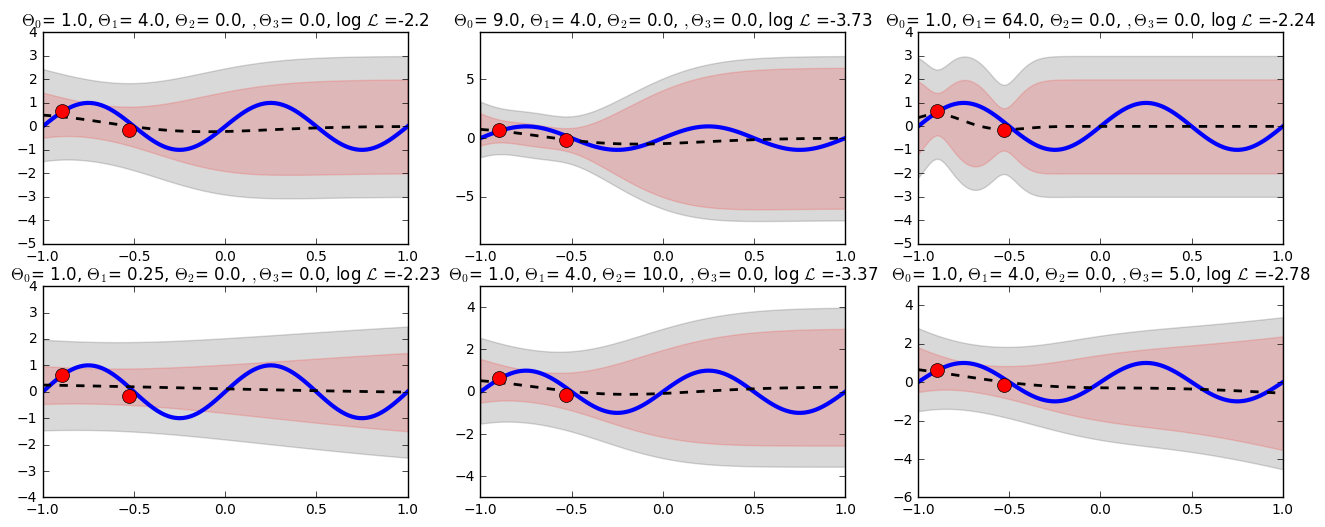

In [30]:
def plot_points(params, sigma, x_train, y_train, t_train, x_test, y_test, doPlot=True):

    # Hyperparams
    beta  = 1.0 / pow(sigma,2) # this is the beta used in Bishop Eqn. 6.59

    # Compute kernels for each Theta config for training data
    kernels = [computeK(x_train, x_train, p) for p in params]

    # Placeholders
    C = None
    invC = None

    # plot
    f, axarr = plt.subplots(2, 3, figsize=(16, 6))
    for i in range(2):
        for j in range(3):
            idx = i*3+j

            theta = params[idx]

            C = noisy_covariance(x_train, theta, beta)
            invC = np.linalg.pinv(C)

            mean_pred, var_pred = gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C, invC)
            logP = gb_log_likelihood(x_train, t_train, theta, C, invC, beta)
            logP = round(logP[0,0],2)

            if doPlot:
                gp_plot(axarr[i,j], x_test, y_test, mean_pred, var_pred, x_train, t_train, theta, beta, logP )


# Different Theta configurations
params = np.asarray([[1,4,0,0],
          [9,4,0,0],
          [1,64,0,0],
          [1,.25,0,0],
          [1,4,10,0],
          [1,4,0,5]],dtype='float64')

# Hyperparams
sigma = 0.5

# Training data (Same as x_test for sec 1.3)
N_train = 2
x_train = np.random.uniform(-1,1,N_train)
y_train =true_mean_function( x_train )
t_train = add_noise( y_train, sigma )

plot_points(params, sigma, x_train, y_train, t_train, x_test, y_test)

#### 2.4 More ploting (5 points)
Repeat the 6 plots above, but this time conditioned a new set of 10 training points. (5 points)

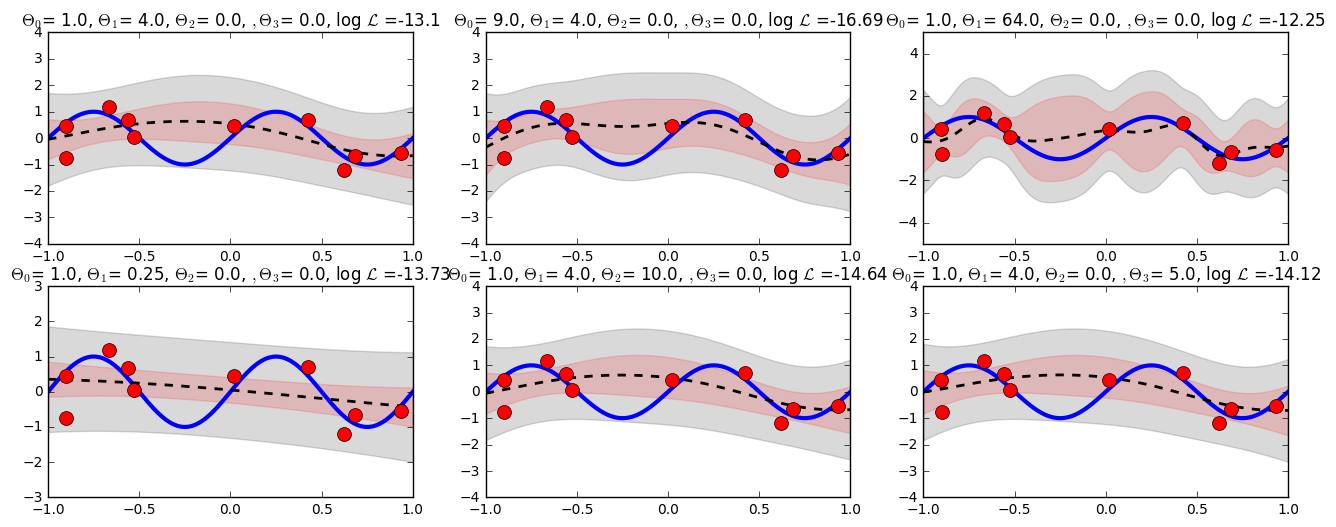

In [31]:
# Different Theta configurations
params = np.asarray([
          [1,4,0,0],
          [9,4,0,0],
          [1,64,0,0],
          [1,.25,0,0],
          [1,4,10,0],
          [1,4,0,5]],dtype='float64')

# Hyperparams
sigma = 0.5

# Training data (Same as x_test for sec 1.3)
N_train = 10
x_train = np.random.uniform(-1,1,N_train)
y_train =true_mean_function( x_train )
t_train = add_noise( y_train, sigma )

plot_points(params, sigma, x_train, y_train, t_train, x_test, y_test)

### 3. Learning the hyperparameters (45 points)

Learning the values of the parameter $\thetav$ can be very tricky for Gaussian processes in general, but when the data is univariate like ours, we can visualize the fit and see how plausible it looks.

#### 3.1 Derivatives (5 points)
Maximum likelihood or MAP learning is the most common way of setting the parameters, though a fully Bayesian approach is possible too.  We will look at ML today.  For this, we start with the dervivative of the log-likelihood with respect to the parameters $\thetav$; this is Eqn 6.70.  This, in turn, requires the derivative of the kernel matrix $\CN$ wrt $\thetav$.  This is the matrix of element-wise derivatives of the kernel function.  Write the derivatives for $\theta_0$ to $\theta_3$ for our kernel function (5 points).  

As we have $$ C_{nm} = K(x_n, x_m) + \beta^{-1} + \delta_{nm}$$

We can see that the derivative $\dfrac{\partial C_{nm}}{\partial \theta_i} = \dfrac{\partial K_{nm}}{\partial \theta_i}$

$$\dfrac{\partial  K_{nm}}{\partial \theta_0} = exp\{\dfrac{-\theta_1}{2} \cdot ||x_n - x_m||^{2}\} \\$$


$$\dfrac{\partial  K_{nm}}{\partial \theta_1} = \theta_0 \cdot exp\{\dfrac{-\theta_1}{2} \cdot ||x_n - x_m||^{2}\} \cdot (- \dfrac{||x_n - x_m||^{2}}{2})$$

$$\dfrac{\partial  K_{nm}}{\partial \theta_2} = 1 \\$$

$$\dfrac{\partial  K_{nm}}{\partial \theta_3} = x_n^T x_m$$

#### 3.2 Questions (5 points)
Which parameters in $\thetav$ are constrained, that is, where not all positive/ negative values are valid? (5 points)

$$k(\bx_n, \bx_m) = \theta_0 \exp \left( {-\frac{\theta_1}{2} || \bx_n - \bx_m||^2} \right) + \theta_2 + \theta_3 \bx_n^T \bx_m$$

The only condition for a valid kernel is its positive-definiteness. We can use the identities in Bishop section 6.2 to define conditions for the validity of our kernel based on the validity of kernels that its composed of. In our kernel above, we can see that it is composed of linear kernels and an exponential kernel. Therefore, based on equations 6.13, 6.14 and 6.16 in Bishop we have the following conditions.


- $\theta_0 > 0$ given eq. 6.13
- $\theta_1 > 0$. If we expand the squared norm, and use Bishop eqs. 6.14 and 6.13 to argue that $\theta_1 x_n^T \cdot x_m$ is only valid if $\theta_1 > 0$.
- $\theta_2$ is mostly unconstrained as it is simply an offset, however it cannot be too negative, as this may weaken the semi-positive definiteness of the kernel K (and positive-definiteness of C).
- $\theta_3 > 0$ as it is a linear kernel, we use eq. 6.13

#### 3.3 More derivatives (5 points)
For parameters that are constrained to be positive, the usual approach is to use the exponential of the free-parameter in the kernel function, but perform gradient ascent on the unconstrained values.  Consider the case  $\theta_i = \exp( \phi_i)$, where $\phi_i$ is unconstrained.  Write the derivative for $\phi_i$ in terms of the derivatives you already computed (5 points).  Hint: use the chain rule and do not repeat the full derivation.


$$\dfrac{\partial  K_{nm}}{\partial \phi_0} = \dfrac{\partial  K_{nm}}{\partial \theta_0} \dfrac{\partial  \theta_0}{\partial \phi_0} = exp\{\dfrac{-\exp(\phi_1)}{2} \cdot ||x_n - x_m||^{2}\} \cdot \exp(\phi_0)\\$$


$$\dfrac{\partial  K_{nm}}{\partial \phi_1} = \dfrac{\partial  K_{nm}}{\partial \theta_1} \dfrac{\partial  \theta_1}{\partial \phi_1}= \exp(\phi_0) \cdot exp\{\dfrac{-\exp(\phi_1)}{2} \cdot ||x_n - x_m||^{2}\} \cdot (- \dfrac{||x_n - x_m||^{2}}{2}) \cdot \exp(\phi_1)$$


$$\dfrac{\partial  K_{nm}}{\partial \phi_3} = \dfrac{\partial  K_{nm}}{\partial \theta_3} \dfrac{\partial  \theta_3}{\partial \phi_3}= x_n^T x_m \cdot \exp(\phi_3)$$

#### 3.4 Grid search (10 points)
Grid-search: for the same training set you have above, perform a small grid search over $\thetav$ (try at least 20 combinations).  Have your grid-search loop or function print out rows of log-likelihood + $\thetav$ sorted by best to worst.  Use the log-likelihood to select the best $\thetav$ and the worst.  Plots both the same way as the subplots above (ie a 1 by 2 subplot of best and worst). (10 points)

In [45]:
from operator import itemgetter
import itertools

def generate_thetas():
    thetas = []
    for i in range(20):
        theta = []
        for j in range(4):
            theta.append(float(np.random.randint(1,50)))
        thetas.append(theta)    
    return thetas

def grid_search(x_train, t_train):
#     thetas = generate_thetas()
    thetas = np.array(list(itertools.product([1,5,10,20],[0.1,1,5,10],[0,5,10,15],[1,5,10])))
    
    likelihoods = {}
   
    beta  = 1.0 / pow(sigma,2) 
    
    for i, theta in enumerate(thetas):
        C = noisy_covariance(x_train, theta, beta)
        invC = np.linalg.pinv(C)
        logP = gb_log_likelihood(x_train, t_train, theta, C, invC, beta)
        likelihoods[tuple(theta)] = logP
        
    # Sort best thetas
    sorted_likelihoods = sorted(likelihoods.items(), key=itemgetter(1))
    
    print "From worst to best: "
    for key in sorted_likelihoods:
        print "Thetas {0} with likelihood: {1}".format(key[0],key[1])
    
    return sorted_likelihoods[0], sorted_likelihoods[-1]

worst, best = grid_search(x_train, t_train)


From worst to best: 
Thetas (20.0, 10.0, 15.0, 10.0) with likelihood: [[-19.73410017]]
Thetas (20.0, 10.0, 10.0, 10.0) with likelihood: [[-19.59984309]]
Thetas (20.0, 10.0, 15.0, 5.0) with likelihood: [[-19.599733]]
Thetas (20.0, 10.0, 10.0, 5.0) with likelihood: [[-19.46546995]]
Thetas (20.0, 10.0, 15.0, 1.0) with likelihood: [[-19.45813649]]
Thetas (20.0, 10.0, 5.0, 10.0) with likelihood: [[-19.41574774]]
Thetas (20.0, 10.0, 10.0, 1.0) with likelihood: [[-19.32386507]]
Thetas (20.0, 10.0, 5.0, 5.0) with likelihood: [[-19.28136327]]
Thetas (20.0, 10.0, 5.0, 1.0) with likelihood: [[-19.13974253]]
Thetas (20.0, 10.0, 0.0, 10.0) with likelihood: [[-19.12126947]]
Thetas (20.0, 10.0, 0.0, 5.0) with likelihood: [[-18.98685524]]
Thetas (20.0, 5.0, 15.0, 10.0) with likelihood: [[-18.97327268]]
Thetas (20.0, 5.0, 15.0, 5.0) with likelihood: [[-18.85338981]]
Thetas (20.0, 5.0, 10.0, 10.0) with likelihood: [[-18.84908248]]
Thetas (20.0, 10.0, 0.0, 1.0) with likelihood: [[-18.84519286]]
Thetas (2

(-10, 10)

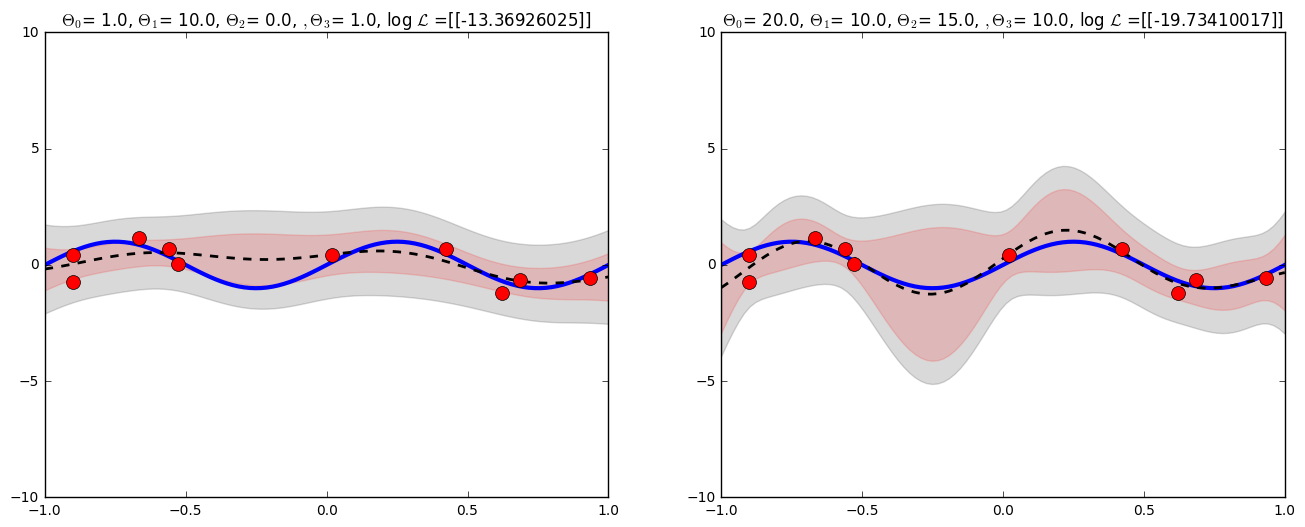

In [46]:
C_best = noisy_covariance(x_train, best[0], beta)
invC_best = np.linalg.pinv(C_best)

C_worst = noisy_covariance(x_train, worst[0], beta)
invC_worst = np.linalg.pinv(C_worst)


mean_pred_best, var_pred_best = gp_predictive_distribution(x_train, t_train, x_test, best[0], beta, C_best, invC_best)
mean_pred_worst, var_pred_worst = gp_predictive_distribution(x_train, t_train, x_test, worst[0], beta, C_worst, invC_worst)

f, axarr = plt.subplots(1, 2, figsize=(16, 6))
gp_plot(axarr[0], x_test, y_test, mean_pred_best, var_pred_best, x_train, t_train, best[0], beta, best[1] )
gp_plot(axarr[1], x_test, y_test, mean_pred_worst, var_pred_worst, x_train, t_train, worst[0], beta, worst[1] )
axarr[0].set_ylim([-10,10])
axarr[1].set_ylim([-10,10])

#### 3.5 Questions (10 points)
Selecting kernel functions can be somewhat of an art.  There are charateristics of kernel functions that are useful for some data sets, but not others.  Complicating the matter is the ability to combine kernels with different characteristics (long term trends + seasonal fluctuations).  Describe the charactistics of the kernel function we are using in terms of (signal, scale, offsets, etc). You may want to play around with $\thetav$ and see what each parameter does/affects/etc.  (5 points)  Describe why the best parameters work well for the training data and explain why the bad parameter settings perform poorly (in terms of the first part of the question).  (5 points)

- $\theta_0$ determines the scale of the stationarity property of the kernel. Small values (close to zero) will restrict the exponential term, and result in a linear kernel with an offset. Large values will allow more flexibility for the exponential term and thus introducing more non-linearity.
- $\theta_1$ determines the signal. Large values result in more granular and wavy mean and confidence interval curves. 
- $\theta_2$ is the intercept
- $\theta_3$ determines the scale of the linear, location-variant similarity in input vectors.

Best parameter setting
- $\theta_0$ = 1 This assignment is appropriate as y is restricted to [-1,1] and does not need a large scaling factor.
- $\theta_1$ = 10 This assignment reflects an appropriate value given the sinusoidal/seasonal behavior of our dataset.
- $\theta_2$ = 0 This assignment makes sense as the mean of our samples and expected value of the prior is zero, i.e. no offset is needed.
- $\theta_3$ = 1 This assignment is appropriate as our sinusoidal dataset requires a stationary kernel more than a non-stationary kernel such as the linear kernel. 

Worst parameter setting
- $\theta_0$ = 20 Given that y is restricted to [-1,1], this scaling factor is too large. Entries in the covariance matrix in our problem should not be too large.
- $\theta_1$ = 10 This does not uniquely contribute to the poor performance of this parameter setting. It is also possible that this is due to the particular sample of the dataset at hand.
- $\theta_2$ = 15 Given that our datapoints are centered around zero, we do not need a large offset.
- $\theta_3$ = 10 Our sinusoidal data does not require such a large dependence on the linear kernel.

#### 3.6 Bonus: Implementation (20 points)
Implement gradient-ascent (or descent if you wish) using the combination of a) the log-likelihood objective function and b) the gradients you calculated above.  Run on the training data above and show the log-likehood curve as it learns and a plot of the final model.  Feel free to use available software (eg search for "minimize.py" which uses conjugate gradient descent, or something in scipy).  NB: log-likelihood should be monotonically increasing.  You are encouraged to also search and use "checkgrad".  (20 points)

In [ ]:
from scipy import optimize

beta = 4

def objective(theta):
    C = noisy_covariance(x_train, theta, beta)
    
    invC = np.linalg.pinv(C)
        
    N = t_train.shape[0]
    t = t_train.reshape(N, -1)
    
    return -.5 * (np.log(np.linalg.det(C)) + t.T.dot(invC.dot(t)) + N * np.log(2*np.pi))

def gradient_theta(theta):
    
    
    
